### Dependency Installation

In [2]:
%%capture
import sys
!{sys.executable} -m pip install torchvision torch onnx numpy onnxruntime
import urllib
import torch
from PIL import Image
import onnx
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
from torchvision import transforms

#Downloads pretrained model
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()


In [3]:
# Opens local image
input_image = Image.open("street_min.jpg")

#Image preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#Execute torch model without GPU acceleration and return predictions/output
with torch.no_grad():
    torch_model = model(input_batch)
    %timeit -n 1 -r 1 model(input_batch) # quick and dirty for benchmarking runtime. timeit and value assigning isn't playing nice
    output = torch_model['out'][0]
output_predictions = output.argmax(0)

#Export pytorch model (for size comparison)
torch.save(model.state_dict(), "deeplabv3_pytorch")

32.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


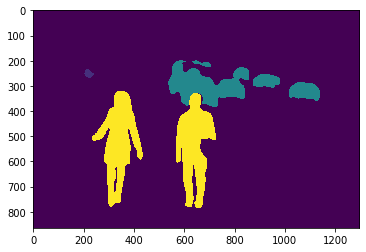

In [4]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

# plot segmentated image
plt.imshow(r)
plt.show()

In [5]:


# Export the model
torch.onnx.export(model,              # model being run
                  input_batch,        # model input (or a tuple for multiple inputs)
                  "deeplabv3.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [6]:
# Check exported model for conversion errors
onnx_model = onnx.load("deeplabv3.onnx")
onnx.checker.check_model(onnx_model)

In [7]:
ort_session = onnxruntime.InferenceSession("deeplabv3.onnx")
def to_numpy(tensor):
    return tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_batch)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results to make sure everything is working as expected
np.testing.assert_allclose(to_numpy(output), ort_outs[0][0], rtol=1e-04, atol=1e-04)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


13.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


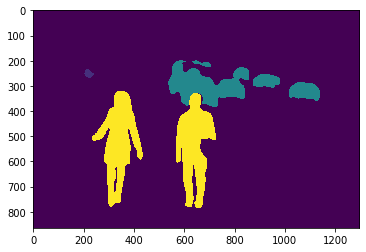

In [8]:
%timeit -n 1 -r 1 ort_session.run(None, ort_inputs) #quick and dirty again for benchmarking
img_ououtput_predictionst_y = ort_outs[0][0]

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

plt.imshow(r)
plt.show()

### Takeaways:
- Execution for this example is significatanly faster, 29 sec in pytorch vs 8 sec in onnxruntime. Doesn't mean all models will run this much faster but it's a good indicator that the advertised runtime opimization seems to have a big impact.
- Exporting the model with pytorch is nativly implemented and easy
- Both models give the same results with a very small margin of error (1e-04)- Solution for image preprocessing must be developed